   student_id    topic  prev_performance  predicted_performance
0           1     math                90              87.666667
1           2  science                85              81.000000
2           3  history                92              87.666667
3           4     math                75              79.333333
4           5  science                85              83.333333
5           6  history                87              88.666667
6           7     math                93              92.333333


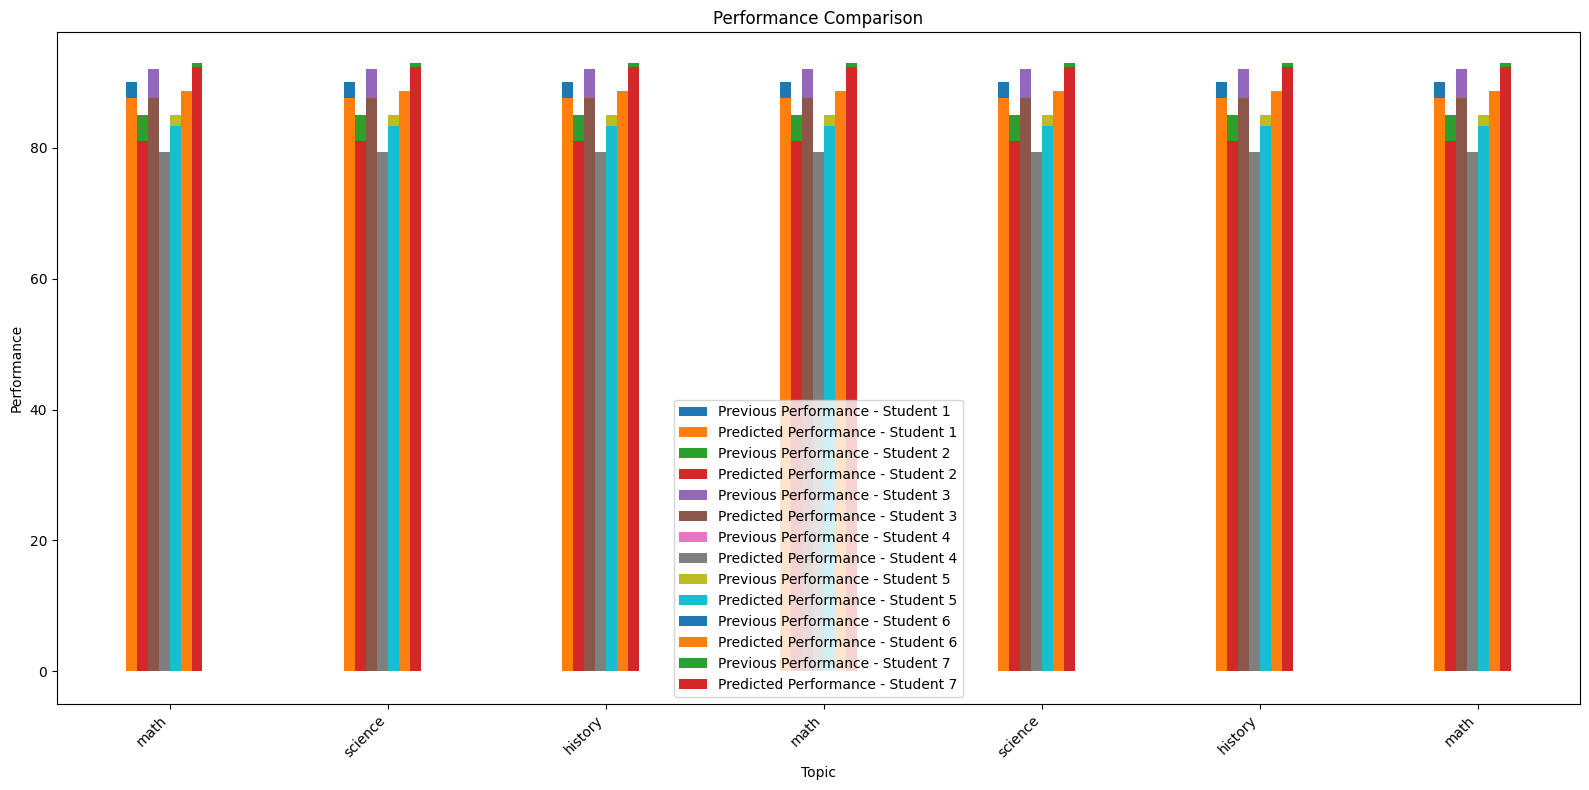

Predicted performance comparison saved as PNG file.


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# Load data from CSV file
df = pd.read_csv('student_performance.csv')

# Sort data by student_id and exam_number to maintain the order of exams
df = df.sort_values(by=['student_id', 'exam_number'])

# Feature extraction: Use previous performances to predict the next one
# Create lag features (previous performances) for each student
df['prev_performance'] = df.groupby('student_id')['performance'].shift(1)
df = df.dropna()  # Drop rows where the previous performance is not available

# Prepare the features and labels
X = df[['student_id', 'topic', 'prev_performance']]
X = pd.get_dummies(X)
y = df['performance']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

# Predicting performance for the next exam for each student
new_student = pd.read_csv('new_student.csv')
new_student['prev_performance'] = new_student['student_id'].map(
    df.groupby('student_id')['performance'].last())

# Handle NaN values in prev_performance
new_student['prev_performance'] = new_student['prev_performance'].fillna(df['performance'].mean())

new_student_encoded = pd.get_dummies(new_student)
new_student_encoded = new_student_encoded.reindex(columns=X.columns, fill_value=0)

# Predict performance
predicted_performance = model.predict(new_student_encoded)

# Print predicted performance for the next exam
new_student['predicted_performance'] = predicted_performance
print(new_student)

# Save predictions to a new CSV file
new_student.to_csv('predicted_performance_next_exam.csv', index=False)

# Plot the performance comparison for all students
fig, ax = plt.subplots(figsize=(16, 8))

width = 0.35  # the width of the bars
num_students = len(new_student['student_id'].unique())
bar_width = width / num_students  # Width of each bar for a student

x_offset = np.arange(len(new_student['topic']))  # X offset for each topic
student_ids = new_student['student_id'].unique()

for i, student_id in enumerate(student_ids):
    student_data = new_student[new_student['student_id'] == student_id]
    prev_performance = student_data['prev_performance']
    predicted_performance = student_data['predicted_performance']

    ax.bar(x_offset + i * bar_width, prev_performance, bar_width, label=f'Previous Performance - Student {student_id}')
    ax.bar(x_offset + i * bar_width, predicted_performance, bar_width, label=f'Predicted Performance - Student {student_id}')

# Adjust y-axis limits to decrease space between bars and y-axis
ax.set_ylim(bottom=-5)  # Adjust as needed

ax.set_xlabel('Topic')
ax.set_ylabel('Performance')
ax.set_title('Performance Comparison')
ax.set_xticks(x_offset + width / 2)
ax.set_xticklabels(new_student['topic'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig("predicted_performance_comparison.png")

# Display the combined graph
plt.show()

print('Predicted performance comparison saved as PNG file.')
